In [1]:
# Install all dependencies (run this cell first in your notebook)
!pip install torch torchvision transformers scikit-learn pandas matplotlib seaborn shap openpyxl --quiet

In [2]:
# Imports
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler, pipeline
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import shap

In [3]:
# Data Loading and Preprocessing
phq_data = pd.read_excel('data/PHQ9_Student_Depression_Dataset_Updated.xlsx')

severity_mapping = {
    'Minimal': 0,
    'Mild': 1,
    'Moderate': 2,
    'Moderately Severe': 3,
    'Severe': 4
}
phq_data['label'] = phq_data['Severity Level'].map(severity_mapping)
text_columns = phq_data.columns[1:9]
phq_data['text'] = phq_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

try:
    train_data = pd.read_csv('data/train.tsv', sep='\t')
    dev_data = pd.read_csv('data/dev.tsv', sep='\t')
    test_data = pd.read_csv('data/test.tsv', sep='\t')
    diary_data = pd.concat([train_data, dev_data, test_data])
    diary_data['label'] = diary_data['Label'].str.lower().map(severity_mapping)
    all_data = pd.concat([
        phq_data[['text', 'label']],
        diary_data.rename(columns={'Text data': 'text'})[['text', 'label']]
    ])
except:
    all_data = phq_data[['text', 'label']]

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [4]:
# Dataset and DataLoader
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [5]:
# Train-validation Split & Dataloaders
from sklearn.model_selection import train_test_split

all_data = all_data.dropna(subset=['text', 'label'])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_data['text'].tolist(),
    all_data['label'].tolist(),
    test_size=0.2,
    stratify=all_data['label'],
    random_state=42
)

train_dataset = DepressionDataset(train_texts, train_labels, tokenizer)
val_dataset = DepressionDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [6]:
# Model, Optimizer, Scheduler, Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\MrsLakshmiKalyani\anaconda3\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
# Training and Evaluation Functions
def train_one_epoch():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = loss_fn(outputs.logits, batch['labels'])
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(train_loader)

def evaluate():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = loss_fn(outputs.logits, batch['labels'])
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == batch['labels']).sum().item()
            total += batch['labels'].size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())
    return total_loss / len(val_loader), correct / total, all_preds, all_labels

In [8]:
# Train Loop
for epoch in range(3):
    print(f"\nEpoch {epoch + 1}/3")
    train_loss = train_one_epoch()
    val_loss, val_acc, _, _ = evaluate()
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


Epoch 1/3
Train Loss: 1.3909 | Val Loss: 1.1488 | Val Acc: 0.7600

Epoch 2/3
Train Loss: 1.0288 | Val Loss: 0.8637 | Val Acc: 1.0000

Epoch 3/3
Train Loss: 0.8525 | Val Loss: 0.7583 | Val Acc: 1.0000


                   precision    recall  f1-score   support

          Minimal       1.00      1.00      1.00         8
             Mild       1.00      1.00      1.00         9
         Moderate       1.00      1.00      1.00         9
Moderately Severe       1.00      1.00      1.00        10
           Severe       1.00      1.00      1.00        14

         accuracy                           1.00        50
        macro avg       1.00      1.00      1.00        50
     weighted avg       1.00      1.00      1.00        50



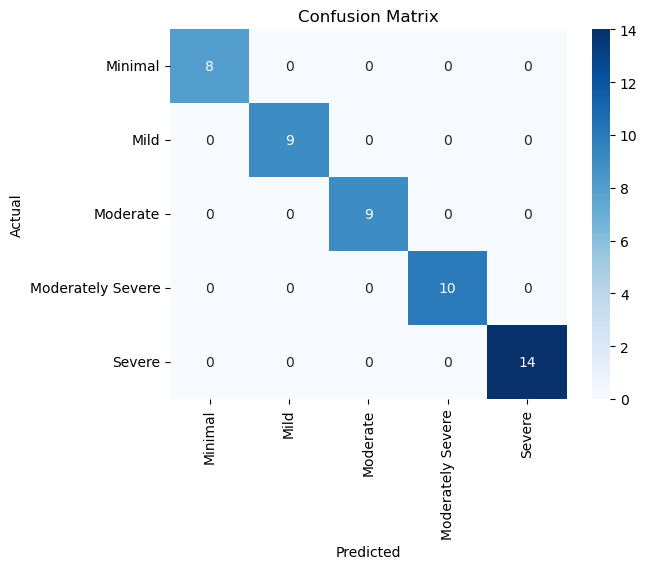

In [9]:
# Final Evaluation and Confusion Matrix
_, _, all_preds, all_labels = evaluate()
print(classification_report(all_labels, all_preds, target_names=severity_mapping.keys()))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=severity_mapping.keys(), yticklabels=severity_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Prediction Function
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()
    return list(severity_mapping.keys())[pred_label], probs.cpu().numpy()

# Example usage
predict("I feel sad and have no interest in daily activities.")

('Moderately Severe',
 array([[0.23971415, 0.16220146, 0.18668056, 0.24445915, 0.1669447 ]],
       dtype=float32))

In [11]:
# Save Model and Tokenizer
save_path = "bert_depression_model"
os.makedirs(save_path, exist_ok=True)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"✅ Model and tokenizer saved to: {save_path}")

✅ Model and tokenizer saved to: bert_depression_model


In [12]:
# HuggingFace Pipeline for SHAP
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

# SHAP Explainer using pipeline
explainer = shap.Explainer(pipe, shap.maskers.Text(tokenizer))

Device set to use cuda:0
c:\Users\MrsLakshmiKalyani\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [13]:
# SHAP word importance visualization
test_text = "I feel sad and have no interest in daily activities."
shap_values = explainer([test_text])
shap.plots.text(shap_values[0])

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


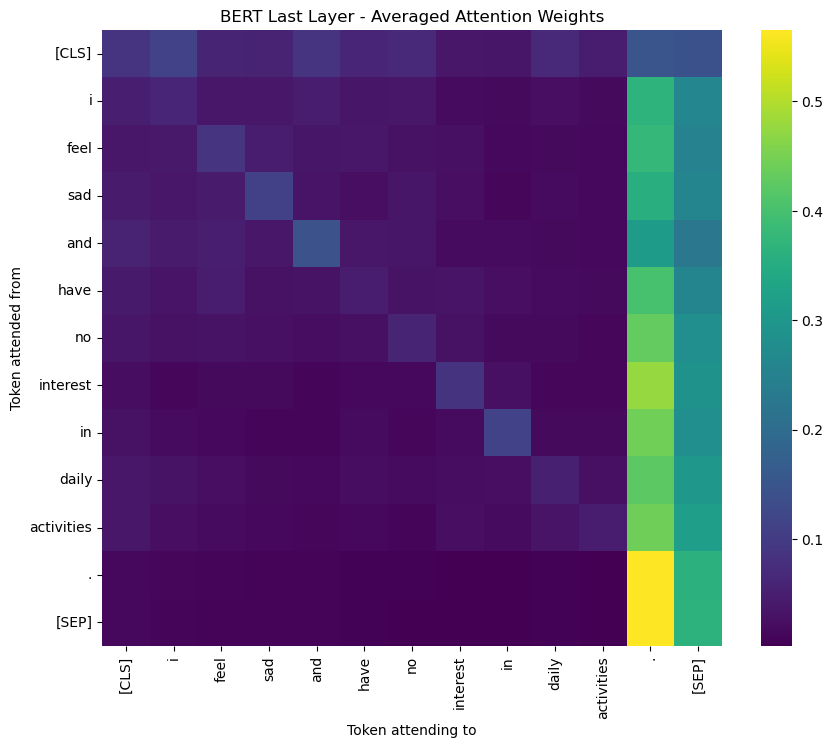

In [14]:
# Attention visualization function
def get_attention(text, model, tokenizer, device):
    encoding = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True,
            output_hidden_states=False,
            return_dict=True
        )
        last_layer_attention = outputs.attentions[-1][0].mean(dim=0).cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    plt.figure(figsize=(10, 8))
    sns.heatmap(last_layer_attention,
                xticklabels=tokens, yticklabels=tokens, cmap='viridis')
    plt.title("BERT Last Layer - Averaged Attention Weights")
    plt.xlabel("Token attending to")
    plt.ylabel("Token attended from")
    plt.show()
    return last_layer_attention, tokens

# Example usage for attention visualization
attention, tokens = get_attention(test_text, model, tokenizer, device)